In [27]:
import os
import xarray as xr
import numpy as np
import pymannkendall as mk
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

def antecedent(ts,m):
    if np.isnan(m):
        return np.nan
    return ts[int(m)-1]

def randn(mu,sigma):
    return np.random.normal(mu,sigma)

root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

ind = 0

cnty_gdp = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_gdp_01-23.csv'))
cnty_gdp = cnty_gdp[cnty_gdp['Description']=='Real GDP (thousands of chained 2017 dollars) ']
cnty_gdp_long = cnty_gdp.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='gdp')
cnty_gdp_long = cnty_gdp_long[cnty_gdp_long['GeoName'].str.contains(",")]
cnty_gdp_long['gdp'] = cnty_gdp_long['gdp'].replace({"(NA)":np.nan})
cnty_gdp_long['gdp'] = 1e3*cnty_gdp_long['gdp'].astype(float)
cnty_gdp_long['year'] = cnty_gdp_long['year'].astype(int)

cnty_pop = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_income_69-23.csv'))
cnty_pop = cnty_pop[cnty_pop['Description']=='Population (persons) 1/']
cnty_pop_long = cnty_pop.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='pop')
cnty_pop_long = cnty_pop_long[cnty_pop_long['GeoName'].str.contains(",")]
cnty_pop_long['pop'] = cnty_pop_long['pop'].replace({"(NA)":np.nan})
cnty_pop_long['pop'] = cnty_pop_long['pop'].astype(float)
cnty_pop_long['year'] = cnty_pop_long['year'].astype(int)

cnty_data = cnty_gdp_long.merge(cnty_pop_long[['GeoFIPS','year','pop']],on=['GeoFIPS','year'])
cnty_data['gdppc'] = cnty_data['gdp']/cnty_data['pop']
cnty_data = cnty_data.rename(columns={"GeoFIPS":"county"})
cnty_ds = xr.Dataset.from_dataframe(cnty_data.set_index(['county','year']))
cnty_ds['growth'] = np.log(cnty_ds['gdppc'])-np.log(cnty_ds['gdppc'].shift(year=1))
gdppc0 = cnty_ds['gdppc'].sel(year=2002).drop("year")

clim_mon = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','county','prism-rain_clsm-grace_mon.nc'))
clim_mon['county'] = clim_mon['county'].astype(int)

clim_mon['rain_clim'] = clim_mon['rain'].groupby("time.month").map(lambda x: x-(x-x.mean('time')))
clim_mon['tws_clim'] = clim_mon['tws_def_ant'].groupby("time.month").map(lambda x: x-(x-x.mean('time')))

clim_mon['p_exc_rain_clim'] = clim_mon['rain_clim']-clim_mon['tws_def_ant']
clim_mon['p_exc_tws_clim'] = clim_mon['rain']-clim_mon['tws_clim']
clim_mon['p_exc_both_clim'] = clim_mon['rain_clim']-clim_mon['tws_clim']
p_exc_max = clim_mon[['p_exc','p_exc_rain_clim','p_exc_tws_clim','p_exc_both_clim']].groupby("time.year").max()
# p_exc_max.name = 'p_exc_max'
# pexcmax_m = clim_mon['p_exc'].groupby("time.year").apply(lambda g: g.idxmax("time").dt.month)
# tws_def_pre = xr.apply_ufunc(antecedent,
#                           clim_mon['tws_def_ant'].groupby("time.year"),
#                           pexcmax_m,
#                           input_core_dims=[['time'],[]],
#                           vectorize=True)
# tws_def_pre.name = 'tws_def_pre_pexcmax'

# rxmon = xr.apply_ufunc(antecedent,
#                           clim_mon['rain'].groupby("time.year"),
#                           # clim_mon['ppt'].groupby("time.year"),
#                           pexcmax_m,
#                           input_core_dims=[['time'],[]],
#                           vectorize=True)
# rxmon.name = 'rxmon'

# clim_ds = xr.merge([rxmon,tws_def_pre])
# clim_ds['p_exc_rxmon'] = clim_ds['rxmon']-clim_ds['tws_def_pre_pexcmax']


In [35]:
coef = pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','county_se','lag1.csv')).set_index('Coefficient')
coef_ds = xr.Dataset.from_dataframe(coef.transpose())

In [131]:
delta_pexc_rain = p_exc_max['p_exc']-p_exc_max['p_exc_rain_clim']
delta_pexc_tws = p_exc_max['p_exc']-p_exc_max['p_exc_tws_clim']
delta_pexc_both = p_exc_max['p_exc']-p_exc_max['p_exc_both_clim']
# delta_pexc_rain.sel(county=50023).plot()
# delta_pexc_tws.sel(county=50023).plot()

In [107]:
coef_ds['p_exc_rxmon_lag1'] = -coef_ds['p_exc_rxmon_lag0']
coef_ds['p_exc_rxmon_sq_lag1'] = -coef_ds['p_exc_rxmon_sq_lag0']

In [108]:
coef_ds['p_exc_rxmon_lag1'] = -coef_ds['p_exc_rxmon_lag0']
coef_ds['p_exc_rxmon_sq_lag1'] = -coef_ds['p_exc_rxmon_sq_lag0']

me_lag0 = coef_ds['p_exc_rxmon_lag0']+2*clim_ds['p_exc_rxmon']*coef_ds['p_exc_rxmon_sq_lag0']
me_lag1 = coef_ds['p_exc_rxmon_lag1']+2*clim_ds['p_exc_rxmon'].shift(year=1)*coef_ds['p_exc_rxmon_sq_lag1']

delta_pexc_rain = xr.where(me_lag0<0,delta_pexc_rain,0)
delta_pexc_tws = xr.where(me_lag0<0,delta_pexc_tws,0)
delta_pexc_both = xr.where(me_lag0<0,delta_pexc_both,0)

delta_gr_rain = delta_pexc_rain*me_lag0+(delta_pexc_rain.shift(year=1)*me_lag1).fillna(0)
delta_gr_tws = delta_pexc_tws*me_lag0+(delta_pexc_tws.shift(year=1)*me_lag1).fillna(0)
delta_gr_both = delta_pexc_both*me_lag0+(delta_pexc_both.shift(year=1)*me_lag1).fillna(0)

In [179]:
delta_gdp_

<xarray.Dataset> Size: 536kB
Dimensions:         (year: 22, index: 1000)
Coordinates:
  * year            (year) int64 176B 2002 2003 2004 2005 ... 2021 2022 2023
  * index           (index) object 8kB '1' '2' '3' '4' ... '998' '999' '1000'
    band            int64 8B 1
    spatial_ref     int64 8B 0
Data variables:
    delta_gdp_rain  (year, index) float64 176kB 0.0 0.0 ... 3.195e+09 1.696e+09
    delta_gdp_tws   (year, index) float64 176kB 0.0 0.0 ... -7.987e+08
    delta_gdp_both  (year, index) float64 176kB 0.0 0.0 ... 3.301e+09 1.701e+09

(array([  1.,   0.,   8.,  37.,  92., 207., 297., 240.,  82.,  36.]),
 array([-6147098.16141987, -5532388.34527788, -4917678.52913589,
        -4302968.71299391, -3688258.89685192, -3073549.08070993,
        -2458839.26456795, -1844129.44842596, -1229419.63228397,
         -614709.81614199,        0.        ]),
 <BarContainer object of 10 artists>)

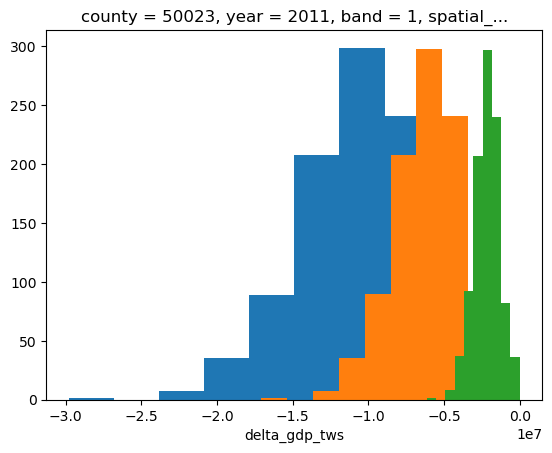

In [181]:
delta_gdp_both.sel(county=50023,year=2011).plot.hist()
delta_gdp_rain.sel(county=50023,year=2011).plot.hist()
delta_gdp_tws.sel(county=50023,year=2011).plot.hist()

In [134]:
gr_cf_rain = cnty_ds['growth']-delta_gr_rain/100
gr_cf_tws = cnty_ds['growth']-delta_gr_tws/100
gr_cf_both = cnty_ds['growth']-delta_gr_both/100

In [135]:
gdppc0 = cnty_ds['gdppc'].sel(year=2002).drop("year")

gr_cf_rain = cnty_ds['growth']-delta_gr_rain/100
gr_cf_tws = cnty_ds['growth']-delta_gr_tws/100
gr_cf_both = cnty_ds['growth']-delta_gr_both/100

gdppc_hist = [gdppc0]
gdppc_cf_rain = [gdppc0]
gdppc_cf_tws = [gdppc0]
gdppc_cf_both = [gdppc0]

for i,y in enumerate(np.arange(2003,2024)):
    gdppc_hist.append(gdppc_hist[i]*(1+cnty_ds['growth'].sel(year=y).drop("year")))
    gdppc_cf_rain.append(gdppc_cf_rain[i]*(1+gr_cf_rain.sel(year=y).drop("year")))
    gdppc_cf_tws.append(gdppc_cf_tws[i]*(1+gr_cf_tws.sel(year=y).drop("year")))
    gdppc_cf_both.append(gdppc_cf_both[i]*(1+gr_cf_both.sel(year=y).drop("year")))

gdppc_hist = xr.concat(gdppc_hist,dim='year')
gdppc_hist['year'] = np.arange(2002,2024)

gdppc_cf_rain = xr.concat(gdppc_cf_rain,dim='year')
gdppc_cf_rain['year'] = np.arange(2002,2024)

gdppc_cf_tws = xr.concat(gdppc_cf_tws,dim='year')
gdppc_cf_tws['year'] = np.arange(2002,2024)

gdppc_cf_both = xr.concat(gdppc_cf_both,dim='year')
gdppc_cf_both['year'] = np.arange(2002,2024)

gdp_hist = gdppc_hist*cnty_ds['pop']
gdp_cf_rain = gdppc_cf_rain*cnty_ds['pop']
gdp_cf_tws = gdppc_cf_tws*cnty_ds['pop']
gdp_cf_both = gdppc_cf_both*cnty_ds['pop']

delta_gdp_rain = gdp_hist-gdp_cf_rain
delta_gdp_rain.name = 'delta_gdp_rain'

delta_gdp_tws = gdp_hist-gdp_cf_tws
delta_gdp_tws.name = 'delta_gdp_tws'

delta_gdp_both = gdp_hist-gdp_cf_both
delta_gdp_both.name = 'delta_gdp_both'

(array([  1.,   0.,   3.,   9.,  36.,  86., 203., 364., 246.,  52.]),
 array([-1.70569487e+11, -1.53914555e+11, -1.37259623e+11, -1.20604691e+11,
        -1.03949759e+11, -8.72948265e+10, -7.06398944e+10, -5.39849622e+10,
        -3.73300300e+10, -2.06750978e+10, -4.02016561e+09]),
 <BarContainer object of 10 artists>)

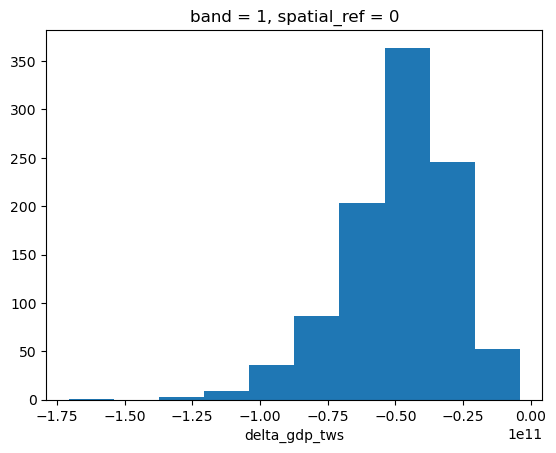

In [136]:
delta_gdp_tws.sum(['county','year']).plot.hist()

(array([  1.,   1.,   5.,  21.,  74., 174., 312., 295., 103.,  14.]),
 array([-3.65017388e+11, -3.31700850e+11, -2.98384312e+11, -2.65067774e+11,
        -2.31751236e+11, -1.98434699e+11, -1.65118161e+11, -1.31801623e+11,
        -9.84850851e+10, -6.51685473e+10, -3.18520095e+10]),
 <BarContainer object of 10 artists>)

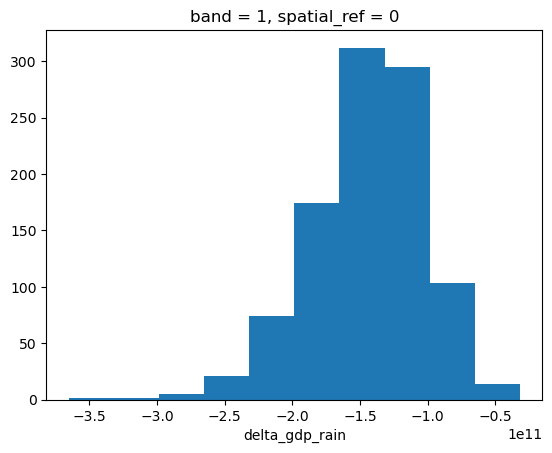

In [130]:
delta_gdp_rain.sum(['county','year']).plot.hist()

(array([  1.,   0.,   5.,  13.,  55., 119., 272., 339., 172.,  24.]),
 array([-5.35928134e+11, -4.85723919e+11, -4.35519705e+11, -3.85315490e+11,
        -3.35111276e+11, -2.84907061e+11, -2.34702847e+11, -1.84498632e+11,
        -1.34294418e+11, -8.40902030e+10, -3.38859885e+10]),
 <BarContainer object of 10 artists>)

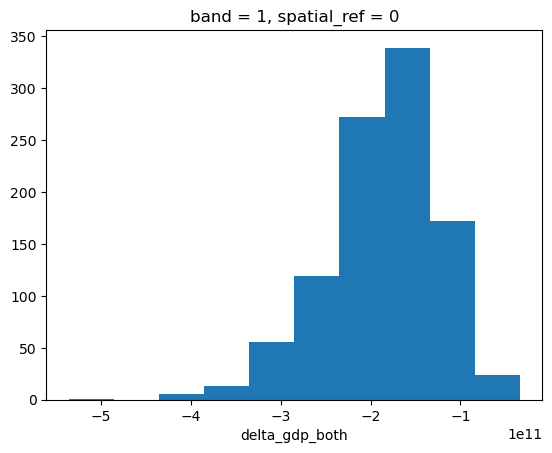

In [137]:
delta_gdp_both.sum(['county','year']).plot.hist()

In [138]:
import geopandas as gpd
gdf = gpd.read_file(os.path.join(project_dir,'data','interim','cnty_bnds_fixed'))


In [146]:
delta_gdp_all = xr.merge([delta_gdp_rain,delta_gdp_tws,delta_gdp_both])
delta_gdp_ann = delta_gdp_all.sum("county")
delta_gdp_cnty = delta_gdp_all.sum("year")

In [ ]:
ax.fill_between(yrs,
                delta_gdp_ann['delta_gdp_both'].quantile(0.025,"index").sel(year=yrs).cumsum("year"),
                delta_gdp_ann['delta_gdp_both'].quantile(0.975,"index").sel(year=yrs).cumsum("year"),
                color='tab:brown',alpha=0.15)

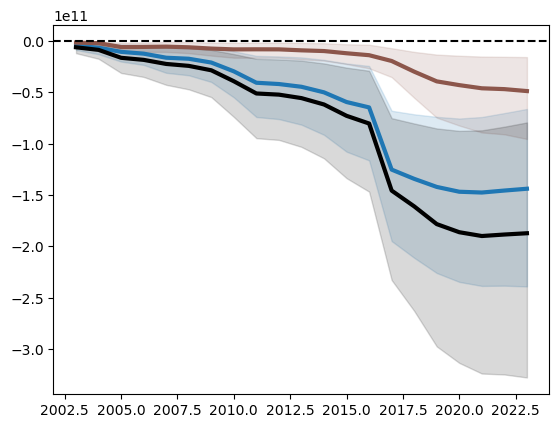

In [157]:
fig,ax=plt.subplots()
yrs = np.arange(2003,2024)
ax.plot(yrs,delta_gdp_ann['delta_gdp_rain'].mean("index").sel(year=yrs).cumsum("year"),color='tab:blue',lw=3)
ax.fill_between(yrs,
                delta_gdp_ann['delta_gdp_rain'].quantile(0.025,"index").sel(year=yrs).cumsum("year"),
                delta_gdp_ann['delta_gdp_rain'].quantile(0.975,"index").sel(year=yrs).cumsum("year"),
                color='tab:blue',alpha=0.15)
ax.plot(yrs,delta_gdp_ann['delta_gdp_tws'].mean("index").sel(year=yrs).cumsum("year"),color='tab:brown',lw=3)
ax.fill_between(yrs,
                delta_gdp_ann['delta_gdp_tws'].quantile(0.025,"index").sel(year=yrs).cumsum("year"),
                delta_gdp_ann['delta_gdp_tws'].quantile(0.975,"index").sel(year=yrs).cumsum("year"),
                color='tab:brown',alpha=0.15)
ax.plot(yrs,delta_gdp_ann['delta_gdp_both'].mean("index").sel(year=yrs).cumsum("year"),color='black',lw=3)
ax.fill_between(yrs,
                delta_gdp_ann['delta_gdp_both'].quantile(0.025,"index").sel(year=yrs).cumsum("year"),
                delta_gdp_ann['delta_gdp_both'].quantile(0.975,"index").sel(year=yrs).cumsum("year"),
                color='black',alpha=0.15)
ax.axhline(0,color='black',linestyle='--')

In [162]:
delta_gdp_cnty[delta_gdp_cnty['state']=='CA']

,county,name,state,geometry,band,spatial_ref,delta_gdp_rain,delta_gdp_tws,delta_gdp_both
78,6025,Imperial County,CA,"POLYGON ((-114.72428 32.71284, -114.76454 32.7...",1,0,0.000000e+00,0.000000e+00,0.000000e+00
79,6073,San Diego County,CA,"POLYGON ((-116.1054 32.60838, -116.16174 32.60...",1,0,-1.248824e+06,-2.246644e+06,-3.695159e+06
287,6015,Del Norte County,CA,"POLYGON ((-124.06932 41.46371, -124.07608 41.4...",1,0,-1.421932e+08,-1.923713e+07,-1.475045e+08
288,6023,Humboldt County,CA,"POLYGON ((-124.02271 40.00214, -124.03346 40.0...",1,0,-5.508911e+08,-6.586338e+07,-5.895771e+08
289,6045,Mendocino County,CA,"POLYGON ((-123.53764 38.77233, -123.55885 38.7...",1,0,-2.037021e+08,-4.641593e+07,-2.498386e+08
290,6097,Sonoma County,CA,"POLYGON ((-123.00228 38.29486, -123.02952 38.3...",1,0,-6.842630e+08,-3.198617e+08,-1.180046e+09
291,6041,Marin County,CA,"POLYGON ((-122.52843 37.81637, -122.53795 37.8...",1,0,-9.999383e+08,-2.602648e+07,-1.211792e+09
292,6095,Solano County,CA,"POLYGON ((-121.68768 38.14745, -121.68948 38.1...",1,0,-6.079398e+04,-1.396720e+05,-2.470560e+05
293,6067,Sacramento County,CA,"POLYGON ((-121.57128 38.09714, -121.5865 38.10...",1,0,-1.074695e+04,-5.407808e+04,-7.616594e+04
294,6077,San Joaquin County,CA,"POLYGON ((-121.58248 38.03578, -121.58021 38.0...",1,0,0.000000e+00,0.000000e+00,0.000000e+00


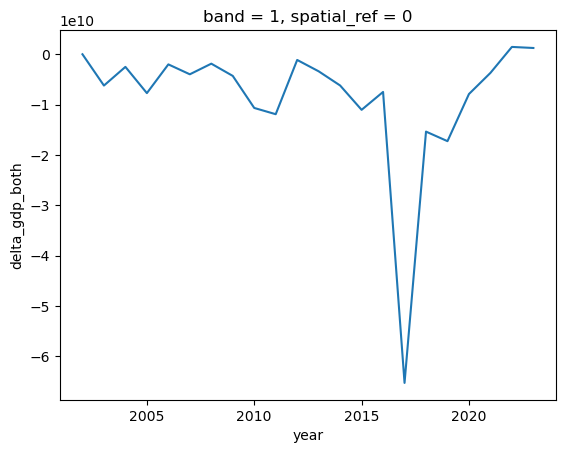

In [160]:
delta_gdp_ann.mean("index")['delta_gdp_both'].plot()

In [147]:
delta_gdp_cnty = gdf.merge(delta_gdp_cnty.mean("index").to_dataframe().reset_index(),on='county')

In [166]:
delta_gdp_cnty['frac_ppt'] = 100*delta_gdp_cnty['delta_gdp_rain']/delta_gdp_cnty['delta_gdp_both']

In [172]:
delta_gdp_cnty.sort_values("frac_ppt")

,county,name,state,geometry,band,spatial_ref,delta_gdp_rain,delta_gdp_tws,delta_gdp_both,frac_ppt
1203,19089,Howard County,IA,"POLYGON ((-92.44894 43.50077, -92.2258 43.5007...",1,0,848497.669811,-8.521465e+05,-40351.483436,-2102.766980
1646,16065,Madison County,ID,"POLYGON ((-111.40069 43.62192, -111.56659 43.6...",1,0,1615.921497,-1.124332e+03,-228.512675,-707.147424
2174,29159,Pettis County,MO,"POLYGON ((-93.06729 38.53009, -93.17848 38.534...",1,0,320959.418112,-5.855601e+05,-80122.146066,-400.587645
1297,21041,Carroll County,KY,"POLYGON ((-85.20554 38.70328, -85.18598 38.693...",1,0,-844570.766721,-6.493850e+05,308158.926877,-274.069869
2497,40073,Kingfisher County,OK,"POLYGON ((-98.2071 35.72513, -98.20681 35.8976...",1,0,930364.927103,-2.457859e+06,-439243.576018,-211.810708
...,...,...,...,...,...,...,...,...,...,...
2895,53043,Lincoln County,WA,"POLYGON ((-117.96013 47.26044, -118.12606 47.2...",1,0,0.000000,0.000000e+00,0.000000,NaN
2896,53077,Yakima County,WA,"POLYGON ((-119.87937 46.64934, -119.87449 46.4...",1,0,0.000000,0.000000e+00,0.000000,NaN
2897,53007,Chelan County,WA,"POLYGON ((-120.70154 48.53161, -120.65173 48.5...",1,0,0.000000,0.000000e+00,0.000000,NaN
2898,53017,Douglas County,WA,"POLYGON ((-120.06823 47.2576, -120.07311 47.28...",1,0,0.000000,0.000000e+00,0.000000,NaN


<Axes: >

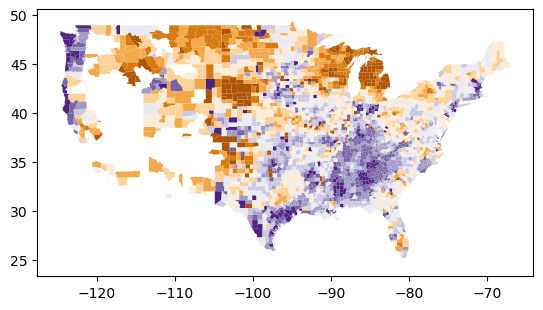

In [170]:
frac_levels = np.arange(0,101,10)
frac_cols = sns.color_palette("PuOr",len(frac_levels)-1)
frac_cmap = mpl.colors.ListedColormap(frac_cols)
frac_norm = plt.Normalize(vmin=0,vmax=100)

delta_gdp_cnty.plot(column='frac_ppt',cmap=frac_cmap,norm=frac_norm)

<Axes: >

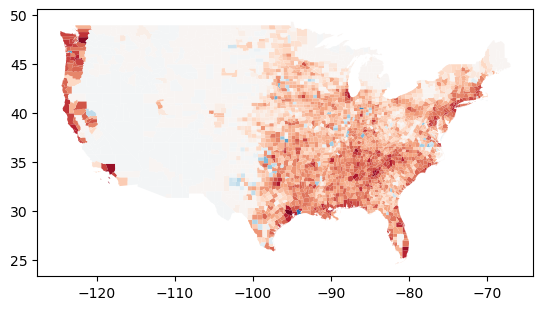

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

dmg_bounds = list(-np.logspace(5,10,21)[::-1])+[0]+list(np.logspace(5,10,21))
dmg_cols = sns.color_palette("RdBu",len(dmg_bounds)-1)
dmg_cmap = mpl.colors.ListedColormap(dmg_cols)
dmg_norm = mpl.colors.BoundaryNorm(dmg_bounds,len(dmg_bounds)-1)
cbar = plt.cm.ScalarMappable(norm=dmg_norm,cmap=dmg_cmap)
delta_gdp_cnty.plot(column='delta_gdp_rain',cmap=dmg_cmap,norm=dmg_norm)

<Axes: >

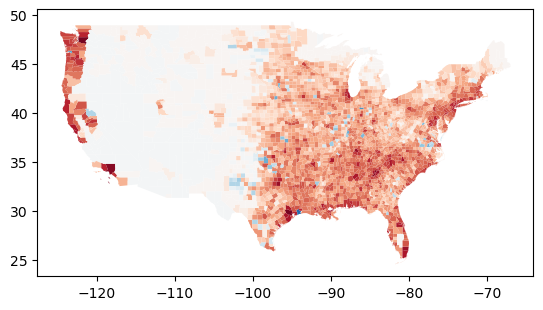

In [144]:
delta_gdp_cnty.plot(column='delta_gdp_both',cmap=dmg_cmap,norm=dmg_norm)

<Axes: >

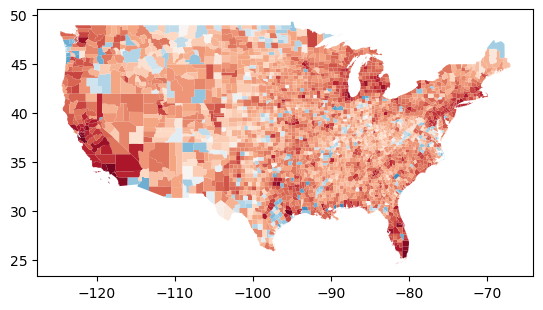

In [116]:
delta_gdp_cnty.plot(column='delta_gdp_tws',cmap=dmg_cmap,norm=dmg_norm)

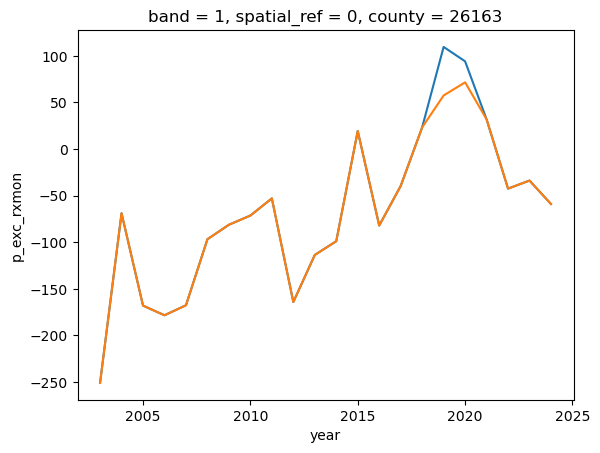

In [144]:
clim_ds['p_exc_rxmon'].sel(county=26163).plot()
clim_ds_cf['p_exc_rxmon'].sel(county=26163).mean("index").plot()

In [141]:
delta_gdp_cnty[delta_gdp_cnty.state=='MI'].sort_values("delta_gdp")

,county,name,state,geometry,band,spatial_ref,delta_gdp
32,26083,Keweenaw County,MI,"MULTIPOLYGON (((-88.23408 47.19991, -88.29843 ...",1,0,0.000000e+00
2013,26013,Baraga County,MI,"POLYGON ((-88.04455 46.91184, -88.0447 46.7653...",1,0,0.000000e+00
2015,26061,Houghton County,MI,"MULTIPOLYGON (((-88.45084 46.93907, -88.45122 ...",1,0,0.000000e+00
671,26131,Ontonagon County,MI,"POLYGON ((-88.93361 47.05249, -88.9333 47.0312...",1,0,3.047207e+02
668,26053,Gogebic County,MI,"POLYGON ((-88.99096 46.09688, -89.03923 46.116...",1,0,4.125370e+03
...,...,...,...,...,...,...,...
2021,26145,Saginaw County,MI,"POLYGON ((-84.16812 43.56889, -84.05071 43.567...",1,0,7.205170e+07
2035,26065,Ingham County,MI,"POLYGON ((-84.60276 42.76987, -84.36366 42.769...",1,0,1.233181e+08
44,26163,Wayne County,MI,"MULTIPOLYGON (((-83.18358 42.03071, -83.19675 ...",1,0,1.572572e+08
2041,26125,Oakland County,MI,"POLYGON ((-83.68649 42.78325, -83.68938 42.871...",1,0,1.950902e+08


In [ ]:
import os
import xarray as xr
import numpy as np
import pymannkendall as mk
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

def antecedent(ts,m):
    if np.isnan(m):
        return np.nan
    return ts[int(m)-1]

def randn(mu,sigma):
    return np.random.normal(mu,sigma)

root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
project_dir = os.path.join(root_dir,'damages','county')

ind = 0

cnty_gdp = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_gdp_01-23.csv'))
cnty_gdp = cnty_gdp[cnty_gdp['Description']=='Real GDP (thousands of chained 2017 dollars) ']
cnty_gdp_long = cnty_gdp.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='gdp')
cnty_gdp_long = cnty_gdp_long[cnty_gdp_long['GeoName'].str.contains(",")]
cnty_gdp_long['gdp'] = cnty_gdp_long['gdp'].replace({"(NA)":np.nan})
cnty_gdp_long['gdp'] = 1e3*cnty_gdp_long['gdp'].astype(float)
cnty_gdp_long['year'] = cnty_gdp_long['year'].astype(int)

cnty_pop = pd.read_csv(os.path.join(project_dir,'data','raw','econ','us_county_income_69-23.csv'))
cnty_pop = cnty_pop[cnty_pop['Description']=='Population (persons) 1/']
cnty_pop_long = cnty_pop.melt(id_vars=['GeoFIPS','GeoName'],value_vars=[str(y) for y in np.arange(2001,2024)],var_name='year',value_name='pop')
cnty_pop_long = cnty_pop_long[cnty_pop_long['GeoName'].str.contains(",")]
cnty_pop_long['pop'] = cnty_pop_long['pop'].replace({"(NA)":np.nan})
cnty_pop_long['pop'] = cnty_pop_long['pop'].astype(float)
cnty_pop_long['year'] = cnty_pop_long['year'].astype(int)

cnty_data = cnty_gdp_long.merge(cnty_pop_long[['GeoFIPS','year','pop']],on=['GeoFIPS','year'])
cnty_data['gdppc'] = cnty_data['gdp']/cnty_data['pop']
cnty_data = cnty_data.rename(columns={"GeoFIPS":"county"})
cnty_ds = xr.Dataset.from_dataframe(cnty_data.set_index(['county','year']))
cnty_ds['growth'] = np.log(cnty_ds['gdppc'])-np.log(cnty_ds['gdppc'].shift(year=1))
gdppc0 = cnty_ds['gdppc'].sel(year=2002).drop("year")

# ppt_scale = xr.open_dataset(os.path.join(project_dir,'data','processed','pattern_scaling','drxmon_dgmst_loca2_county.nc'))
# ppt_scale['county'] = ppt_scale['county'].astype(int)
# ppt_scale['m'] = (('model'),[s.split("_")[0] for s in ppt_scale['model'].values])
# ppt_scale = ppt_scale.groupby("m").mean("model")
ppt_scale = xr.open_dataset(os.path.join(project_dir,'data','processed','pattern_scaling','drxmon_dgmst_withse_prism.nc')).isel(beta=0)

fair_dir = os.path.join(project_dir,'data','interim','fair_outputs')
fair = xr.open_dataset(os.path.join(fair_dir,'fair_gmst_scenarios_1750-2024.nc'))
dgmst = fair.sel(scenario='medium-extension')-fair.sel(scenario='no-ffi')
dgmst = dgmst.rename({"timebounds":"year"})
n_fair = len(dgmst['config'])

clim_mon = xr.open_dataset(os.path.join(project_dir,'data','processed','excess_precip_stats_mon','county','prism_clsm-grace_mon.nc'))
clim_mon = clim_mon.rename({"region":"county"})
clim_mon['county'] = clim_mon['county'].astype(int)

p_exc_max = clim_mon['p_exc'].groupby("time.year").max()
p_exc_max.name = 'p_exc_max'
pexcmax_m = clim_mon['p_exc'].groupby("time.year").apply(lambda g: g.idxmax("time").dt.month)
tws_def_pre = xr.apply_ufunc(antecedent,
                          clim_mon['tws_def_ant'].groupby("time.year"),
                          pexcmax_m,
                          input_core_dims=[['time'],[]],
                          vectorize=True)
tws_def_pre.name = 'tws_def_pre_pexcmax'

rxmon = xr.apply_ufunc(antecedent,
                          clim_mon['ppt'].groupby("time.year"),
                          pexcmax_m,
                          input_core_dims=[['time'],[]],
                          vectorize=True)
rxmon.name = 'rxmon'

clim_ds = xr.merge([rxmon,tws_def_pre])

coef = pd.read_csv(os.path.join(project_dir,'data','processed','damage_func_coefs','county_se','base.csv')).set_index('Coefficient')
coef_ds = xr.Dataset.from_dataframe(coef.transpose())
n_coef = len(coef_ds['index'])
for v in list(coef_ds.data_vars):
    coef_ds[f'{v}_lag1'] = -(coef_ds[v])
    
 

In [ ]:
tws_scale = xr.open_dataset(os.path.join(project_dir,'data','processed','pattern_scaling','dtws_dgmst_withse_gracerecjpl.nc')).isel(beta=0)
n_tws_scale = len(tws_scale['ens_no'])

In [ ]:
clim_ds['p_exc_rxmon'] = clim_ds['rxmon']-clim_ds['tws_def_pre_pexcmax']


In [ ]:
ppt_scale.sel(county=53033)

In [ ]:

n_boot = 1000
boot_out = []
for b in range(n_boot):
    how = 'tws'
    fair_ind = np.random.randint(n_fair)
    coef_ind = np.random.randint(n_coef)
    tws_scale_ind = np.random.randint(n_tws_scale)

    _coef_ds = coef_ds.isel(index=coef_ind)
    me = _coef_ds['p_exc_rxmon']+2*clim_ds['p_exc_rxmon']*_coef_ds['p_exc_rxmon_sq']


    drxmon_dgmst = xr.apply_ufunc(randn,
                                  ppt_scale['drxmon_dgmst'],
                                  ppt_scale['se'],
                                  input_core_dims=[[],[]],
                                  vectorize=True)

    drxmon = dgmst['gmst'].sel(year=slice(2003,2024)).isel(config=fair_ind)*drxmon_dgmst

    dtws_dgmst = xr.apply_ufunc(randn,
                                  tws_scale.isel(ens_no=tws_scale_ind)['dtws_dgmst'],
                                  tws_scale.isel(ens_no=tws_scale_ind)['se'],
                                  input_core_dims=[[],[]],
                                  vectorize=True)

    dtws = dgmst['gmst'].sel(year=slice(2003,2024)).isel(config=fair_ind)*dtws_dgmst

    if how=='ppt':
        p_exc_cf = xr.where(me>0,clim_ds['p_exc_rxmon'],(clim_ds['rxmon']-drxmon)-clim_ds['tws_def_pre_pexcmax'])
    elif how=='tws':
        p_exc_cf = xr.where(me>0,clim_ds['p_exc_rxmon'],clim_ds['rxmon']-(clim_ds['tws_def_pre_pexcmax']+dtws))
    elif how=='both':
        p_exc_cf = xr.where(me>0,clim_ds['p_exc_rxmon'],(clim_ds['rxmon']-drxmon)-(clim_ds['tws_def_pre_pexcmax']+dtws))
    elif how=='noflood':
        p_exc_cf = xr.where(me>0,clim_ds['p_exc_rxmon'],0)
    gr_hist = clim_ds['p_exc_rxmon']*(_coef_ds['p_exc_rxmon']+2*clim_ds['p_exc_rxmon']*_coef_ds['p_exc_rxmon_sq'])
    gr_hist += (clim_ds['p_exc_rxmon'].shift(year=1)*(_coef_ds['p_exc_rxmon_lag1']+2*clim_ds['p_exc_rxmon'].shift(year=1)*_coef_ds['p_exc_rxmon_sq_lag1'])).fillna(0)

    gr_cf = p_exc_cf*(_coef_ds['p_exc_rxmon']+2*p_exc_cf*_coef_ds['p_exc_rxmon_sq'])
    gr_cf += (p_exc_cf.shift(year=1)*(_coef_ds['p_exc_rxmon_lag1']+2*p_exc_cf.shift(year=1)*_coef_ds['p_exc_rxmon_sq_lag1'])).fillna(0)

    delta_gr = gr_cf-gr_hist

    growth_cf = cnty_ds['growth']+delta_gr/100

    gdppc_hist = [gdppc0]
    gdppc_cf = [gdppc0]
    for i,y in enumerate(np.arange(2003,2024)):
        gdppc_hist.append(gdppc_hist[i]*(1+cnty_ds['growth'].sel(year=y).drop("year")))
        gdppc_cf.append(gdppc_cf[i]*(1+growth_cf.sel(year=y).drop("year")))

    gdppc_hist = xr.concat(gdppc_hist,dim='year')
    gdppc_hist['year'] = np.arange(2002,2024)

    gdppc_cf = xr.concat(gdppc_cf,dim='year')
    gdppc_cf['year'] = np.arange(2002,2024)


    gdp_hist = gdppc_hist*cnty_ds['pop']
    gdp_cf = gdppc_cf*cnty_ds['pop']

    delta_gdp_cf = gdp_hist-gdp_cf
    delta_gdp_cf.name = 'delta_gdp'

    delta_gdp_cf = delta_gdp_cf.assign_coords(b=1000*ind+b)
    boot_out.append(delta_gdp_cf)

In [ ]:
boot_out = xr.concat(boot_out,dim='b')
boot_out['b'] = np.arange(n_boot)+1

In [ ]:
boot_out.sel(county=53033).mean("b").plot()

In [ ]:
boot_out.sum(['county','year']).plot.hist()

In [ ]:
tot_df = boot_out.sum("year").mean("b").to_dataframe().reset_index()
import geopandas as gpd
import xarray as xr
gdf = gpd.read_file(os.path.join(root_dir,'Data','Other','tl_2024_us_county')).rename(columns={"GEOID":"county"})
gdf['county'] = gdf['county'].astype(int)
gdf =gdf[gdf.STATEFP!='02']
gdf =gdf[gdf.STATEFP!='15']
tot_df = gdf.merge(tot_df,on='county')

In [ ]:
tot_df[tot_df.delta_gdp.isnull()]

In [ ]:
import seaborn as sns
import matplotlib as mpl
dmg_bounds = list(-np.logspace(5,10,21)[::-1])+[0]+list(np.logspace(5,10,21))
dmg_cols = sns.color_palette("RdBu",len(dmg_bounds)-1)
dmg_cmap = mpl.colors.ListedColormap(dmg_cols)
dmg_norm = mpl.colors.BoundaryNorm(dmg_bounds,len(dmg_bounds)-1)
tot_df.plot(column='delta_gdp',cmap=dmg_cmap,norm=dmg_norm)

In [ ]:
clim_ds['p_exc_rxmon'].sel(county=48201).plot()
p_exc_cf.sel(county=48201).plot()